# Initialising Notebook

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive

Mounted at /content/gdrive
/content/gdrive/My Drive


In [2]:
import pandas as pd
import numpy as np
import math 
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid")
np.random.seed(0)
import matplotlib.pyplot as plt
import matplotlib
import ast
from wordcloud import WordCloud
from collections import Counter

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["xtick.labelsize"] = 7
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head(5)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [4]:
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

# Feature Visualisation

### Fixing dates

In [5]:
def fix_date(x):
    """
    Fixes dates which are in 20xx
    """
    year = x.split('/')[2]
    if int(year) <= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year

# creating features based on dates
def process_date(df):
    date_parts = ["year", "weekday", "month", 'weekofyear', 'day', 'quarter']
    for part in date_parts:
        part_col = 'release_date' + "_" + part
        df[part_col] = getattr(df['release_date'].dt, part).astype(int)
    
    return df

train['release_date'] = train['release_date'].apply(lambda x: fix_date(x))
train['release_date'] = pd.to_datetime(train['release_date'])
train = process_date(train)

## Target

Text(0.5, 1.0, 'Plot of revenue')

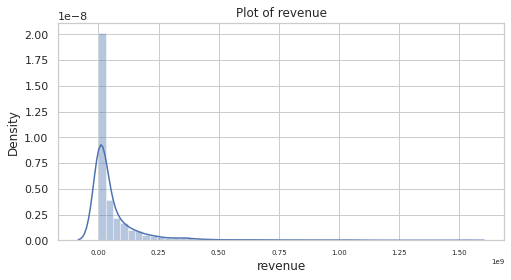

In [6]:
sns.distplot(train['revenue'])
plt.title("Plot of revenue")

Text(0.5, 0, 'Log of revenue')

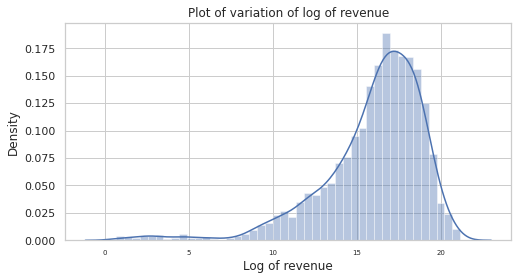

In [7]:
train['log_revenue'] = np.log1p(train['revenue'])
sns.distplot(train['log_revenue'])
plt.title("Plot of variation of log of revenue")
plt.ylabel("Density")
plt.xlabel("Log of revenue")

In [8]:
from scipy.stats import skew, boxcox
print('Skew of train budget attribute: %0.1f' % skew(train['budget']))
print('Skew of test budget attribute: %0.1f' % skew(test['budget']))

Skew of train budget attribute: 3.1
Skew of test budget attribute: 2.7


## Genres

NaN entries in the genre column: 7
Number of genres in films: 872


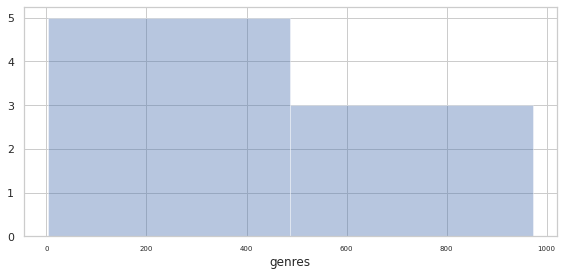

In [10]:
print("NaN entries in the genre column: %d" % train[(train['genres'].isnull()==True)].shape[0])
train[(train['genres'].isnull()==True)].head()
print('Number of genres in films: %d' % train[(train['genres'].isnull()==False)]['genres'].unique().shape)
genres_num = train['genres'].apply(lambda x: (len(ast.literal_eval(x))) if (x != {} and not pd.isnull(x)) else 0).value_counts()
plt.figure(figsize = (8, 4)) 
sns.distplot(genres_num, kde=False)
plt.tight_layout()
plt.show()

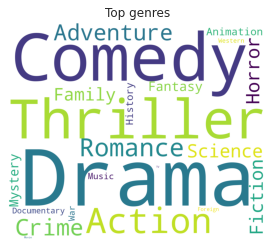

In [11]:
train['duplicated_genres'] = train['genres']
list_of_genres = list(train['genres'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if (x != {} and not pd.isnull(x)) else []).values)                                  

plt.figure(figsize = (8, 4))
text = ' '.join([i for j in list_of_genres for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top genres')
plt.axis("off")
plt.show()

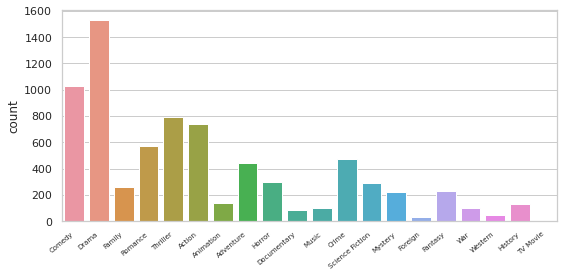

In [12]:
from collections import Counter
plt.figure(figsize=(8,4))
ax = sns.countplot(list(Counter([i for j in list_of_genres for i in j]).elements()))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [13]:
train['genres'] = train['duplicated_genres']
train['genres'].apply(lambda x: len(ast.literal_eval(x)) if (x != {} and not pd.isnull(x)) else 0).value_counts()
train['num_genres'] = train['genres'].apply(lambda x: len(ast.literal_eval(x)) if (x != {} and not pd.isnull(x)) else 0)
train['all_genres'] = train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in ast.literal_eval(x)])) if (x != {} and not pd.isnull(x)) else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
for g in top_genres:
    train['genre_' + g] = train['all_genres'].apply(lambda x: 1 if g in x else 0)
    
train = train.drop(['genres'], axis=1)
drama=train.loc[train['genre_Drama']==1,]
comedy=train.loc[train['genre_Comedy']==1,]
action=train.loc[train['genre_Action']==1,]
thriller=train.loc[train['genre_Thriller']==1,]

drama_revenue=drama.groupby(['release_date_year']).mean()['revenue']
comedy_revenue=comedy.groupby(['release_date_year']).mean()['revenue']
action_revenue=action_revenue=action.groupby(['release_date_year']).mean()['revenue']
thriller_revenue=thriller.groupby(['release_date_year']).mean()['revenue']

revenue_concat = pd.concat([drama_revenue,comedy_revenue,action_revenue,thriller_revenue], axis=1)
revenue_concat.columns=['drama','comedy','action','thriller']
revenue_concat.index=train.groupby(['release_date_year']).mean().index

import plotly.graph_objs as go
import plotly.offline as py
data = [go.Scatter(x=revenue_concat.index, y=revenue_concat.drama, name='drama'), go.Scatter(x=revenue_concat.index, y=revenue_concat.comedy, name='comedy'),
       go.Scatter(x=revenue_concat.index, y=revenue_concat.action, name='action'),go.Scatter(x=revenue_concat.index, y=revenue_concat.thriller, name='thriller')]
layout = go.Layout(dict(title = 'Mean Revenue by Top 4 Movie Genres Over Years',
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Revenue'),
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

## Belongs to collection

In [14]:
non_na_collections = train['belongs_to_collection'][(train['belongs_to_collection'].isnull()==False)]
collections = {}
for df_entry in non_na_collections:
  list_collections = ast.literal_eval(df_entry)
  for entry in list_collections:
    if (entry['name']) in collections.keys():
      collections[entry['name']]+=1
    else:
      collections[entry['name']]=1
pd.Series(collections).sort_values()
list_of_collections = list(train['belongs_to_collection'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if (x != {} and not pd.isnull(x)) else []).values)    

revenue_by_collection = {}
for i, df_entry in enumerate(list_of_collections):
  for collection in df_entry:
    if collection in revenue_by_collection.keys():
      revenue_by_collection[collection]+=train['revenue'].iloc[i]
    else:
      revenue_by_collection[collection]=train['revenue'].iloc[i]


Text(0.5, 1.0, 'Box office revenue for some famous franchises')

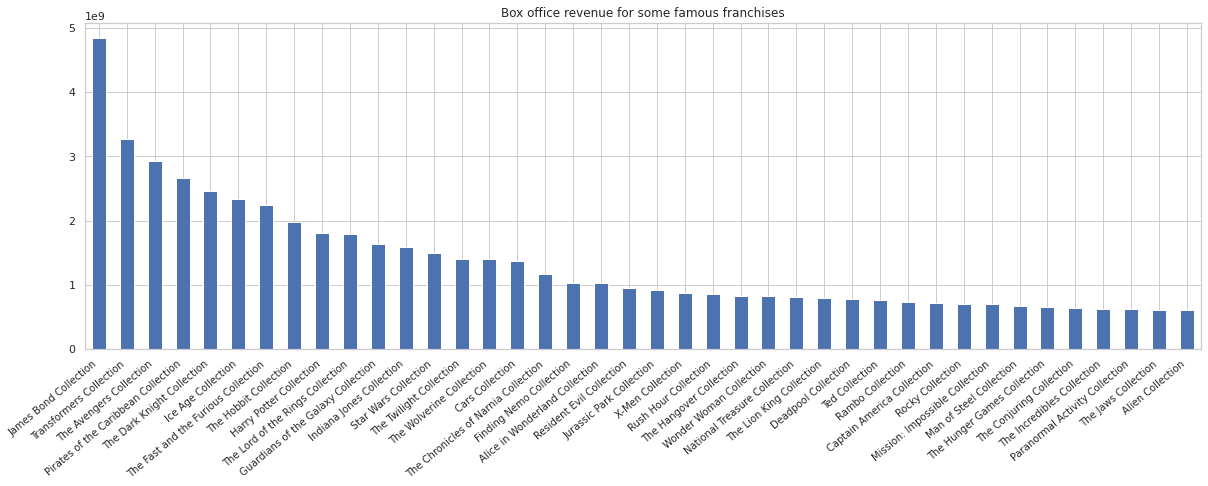

In [15]:
plt.figure(figsize=(20,6))
ax = pd.Series(revenue_by_collection).sort_values(ascending=False)[:40].plot.bar()
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=10)
plt.title("Box office revenue for some famous franchises")

## Budget

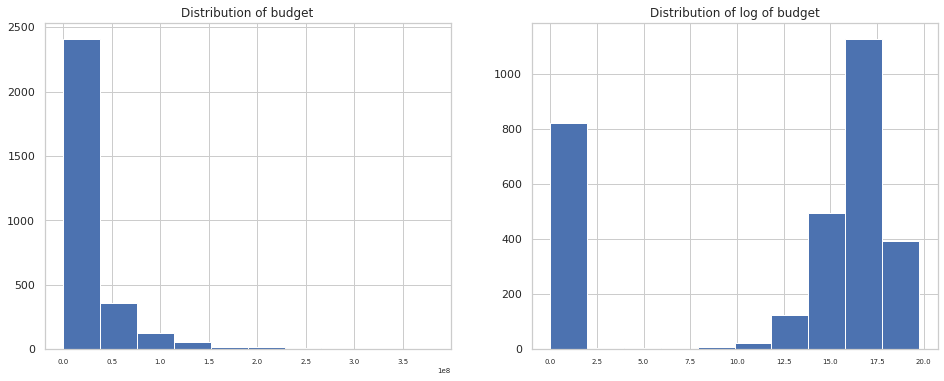

In [16]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['budget']);
plt.title('Distribution of budget');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['budget']));
plt.title('Distribution of log of budget');

Companies with 0$ budget: (812,)
Total rows: (3000,)


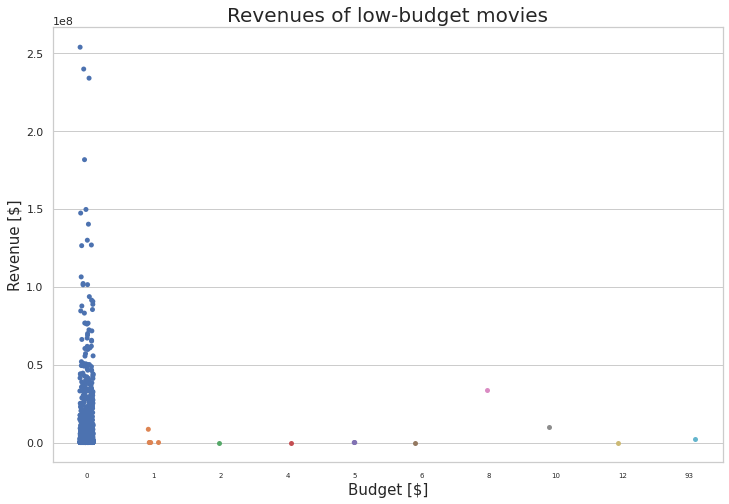

In [17]:
plt.figure(figsize=(12, 8))
logical_mask = train['budget'] < 100
sns.stripplot(x='budget', y='revenue', data=train[logical_mask], jitter=True)
plt.xlabel('Budget [$]', fontsize=15)
plt.ylabel('Revenue [$]', fontsize=15)
plt.title('Revenues of low-budget movies', fontsize=20)
print("Companies with 0$ budget: " + str(train.loc[train['budget'] == 0, 'budget'].shape))
print("Total rows: " + str(train['budget'].shape))

In [18]:
print(train.loc[train['budget']==np.nan].shape)
print(train.shape)

(0, 47)
(3000, 47)


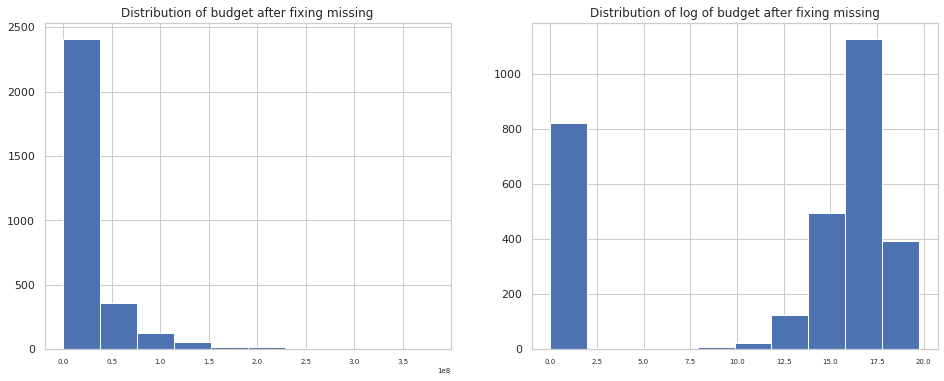

In [19]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['budget']);
plt.title('Distribution of budget after fixing missing');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['budget']));
plt.title('Distribution of log of budget after fixing missing');

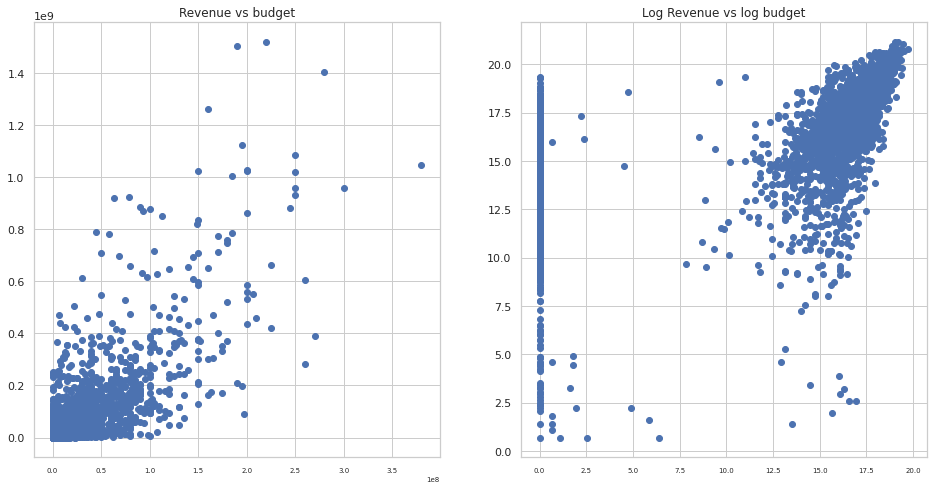

In [20]:
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])
train['log_revenue'] = np.log1p(train['revenue'])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['budget'], train['revenue'])
plt.title('Revenue vs budget');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['budget']), train['log_revenue'])
plt.title('Log Revenue vs log budget');

## Homepage

In [21]:
train['homepage'].value_counts().head()

http://www.transformersmovie.com/                  4
http://www.thehobbit.com/                          2
http://www.lordoftherings.net/                     2
http://www.zookeeper-movie.com/                    1
http://www.thenextthreedaysmovie.com/index.html    1
Name: homepage, dtype: int64

In [22]:
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1
test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1

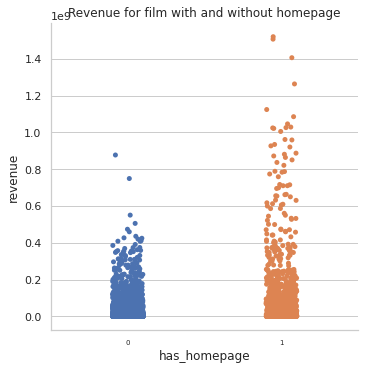

In [23]:
sns.catplot(x='has_homepage', y='revenue', data=train);
plt.title('Revenue for film with and without homepage');

## Status

Released    2996
Rumored        4
Name: status, dtype: int64


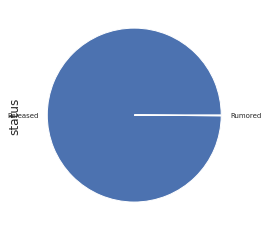

In [24]:
train['status'].value_counts().plot.pie(subplots=True)
print(train['status'].value_counts())

Released           4389
Post Production       5
Rumored               2
Name: status, dtype: int64


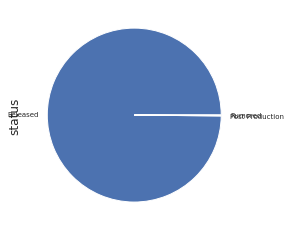

In [25]:
test['status'].value_counts().plot.pie(subplots=True)
print(test['status'].value_counts())

Only 4 films in train data and 7 films in test data are not released yet, so this feature is quite useless

## Tagline

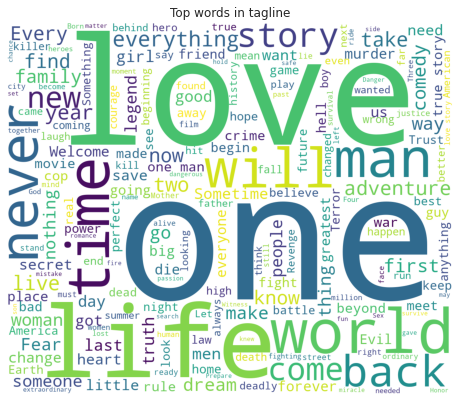

In [26]:
plt.figure(figsize = (8, 8))
text = ' '.join(train['tagline'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in tagline')
plt.axis("off")
plt.show()

In [27]:
train['has_tagline'] = 0
train.loc[train['tagline'].isnull() == False, 'has_tagline'] = 1
test['has_tagline'] = 0
test.loc[test['tagline'].isnull() == False, 'has_tagline'] = 1

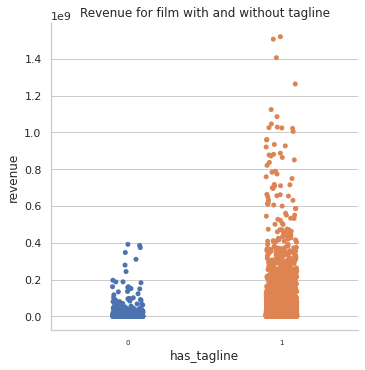

In [28]:
sns.catplot(x='has_tagline', y='revenue', data=train);
plt.title('Revenue for film with and without tagline');

## Title

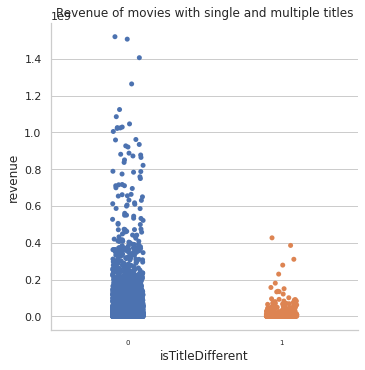

In [29]:
train['isTitleDifferent'] = 1
train.loc[ train['original_title'] == train['title'] ,"isTitleDifferent"] = 0 
sns.catplot(x="isTitleDifferent", y="revenue", data=train)
plt.title('Revenue of movies with single and multiple titles');

The correlation between the length of title and revenue is 0.10966427167156541


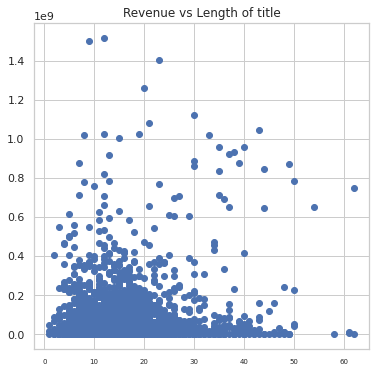

In [30]:
from scipy.stats import pearsonr
y = train['title'].apply(lambda x: len(x))
plt.figure(figsize=(6, 6))
plt.scatter(y, train['revenue'])
plt.title('Revenue vs Length of title');
corr,_ = pearsonr(y,train['revenue'])
print("The correlation between the length of title and revenue is {}".format(corr))

False    2910
True       90
Name: Sequel, dtype: int64

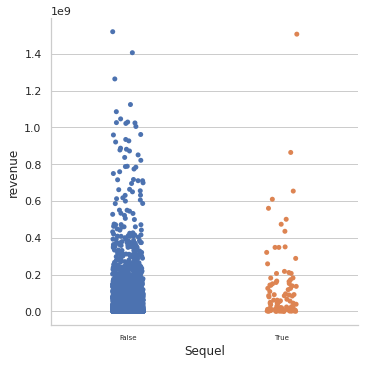

In [31]:
def checkString(s):
    flag_n = False
    if s[-1].isdigit() and len(s)>1 and s[-2]==' ':
      flag_n = True 
    flag_l = False
    for i in range(1,len(s)-1): 
      if s[i].isdigit() and s[i+1]==':' and s[i-1]==' ': 
        flag_l = True
    return flag_l or flag_n

train['Sequel'] = train['title'].apply(checkString)
sns.catplot(x='Sequel',y='revenue',data = train)

train['Sequel'].value_counts()

## Cast

In [32]:
list_of_cast_names = list(train['cast'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if (x != {} and not pd.isnull(x)) else []).values)

train['num_cast'] = train['cast'].apply(lambda x: len(ast.literal_eval(x)) if (x != {} and not pd.isnull(x)) else 0)

top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(15)]
for g in top_cast_names:
    train['cast_name_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)

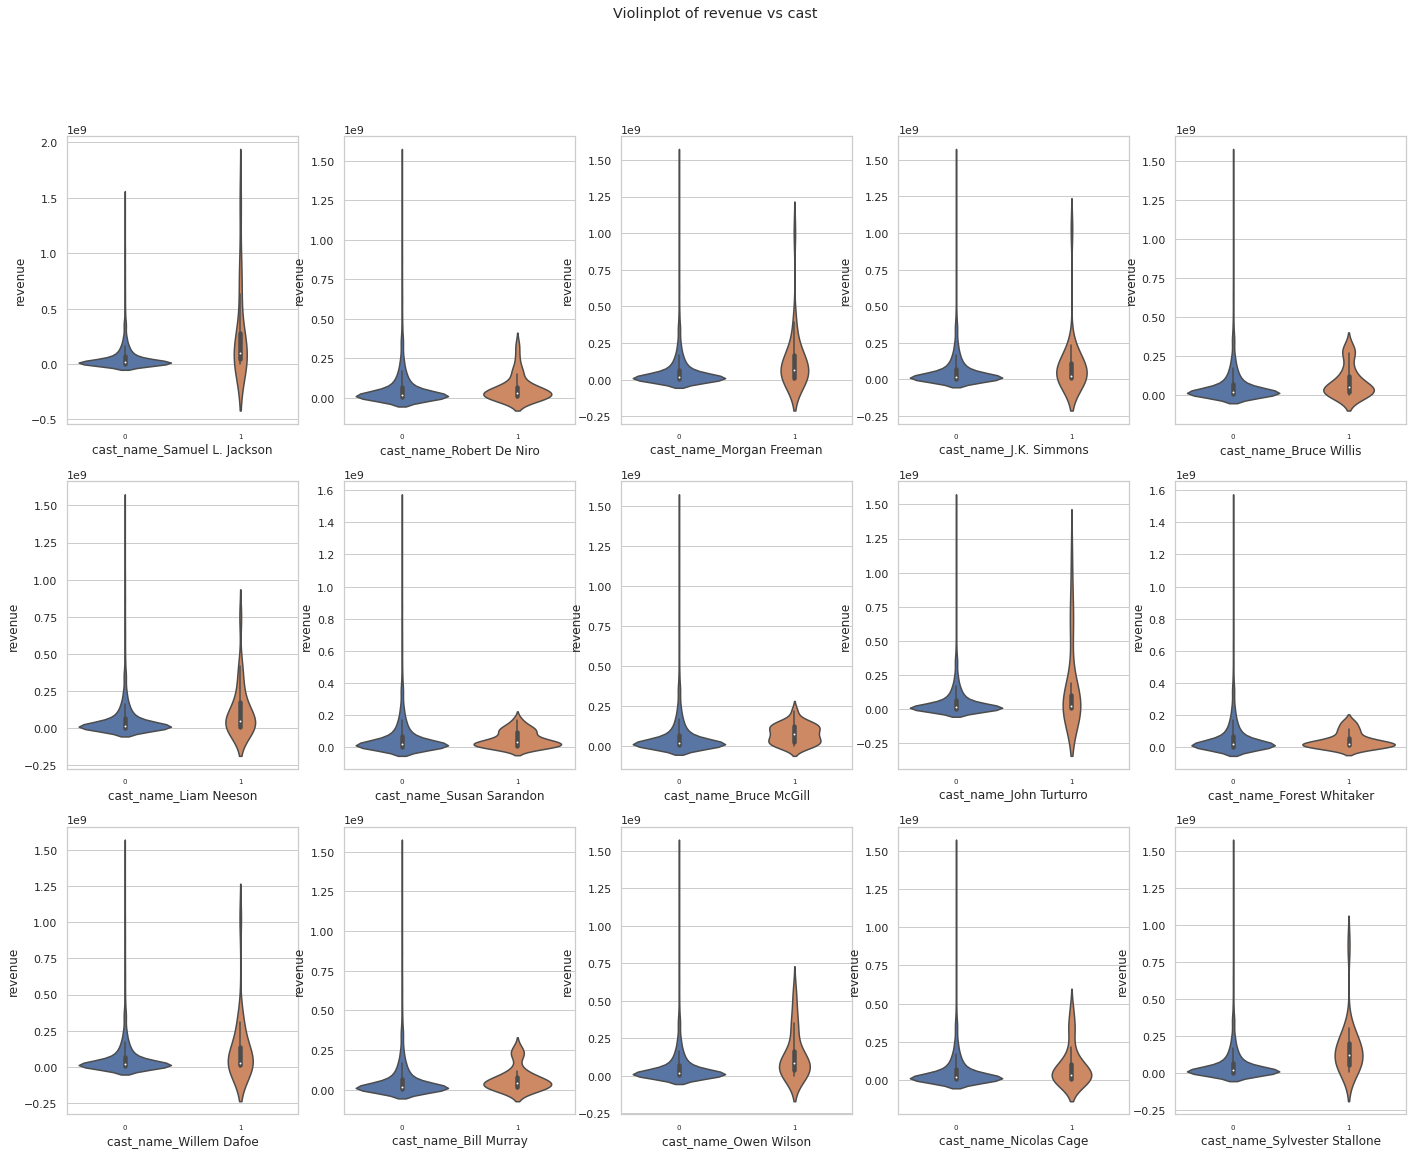

In [33]:
train['genders_0_cast'] = train['cast'][(train['cast'].isnull()==False)].apply(lambda x: sum([1 for i in ast.literal_eval(x) if i['gender'] == 0]))
train['genders_1_cast'] = train['cast'][(train['cast'].isnull()==False)].apply(lambda x: sum([1 for i in ast.literal_eval(x) if i['gender'] == 1]))
train['genders_2_cast'] = train['cast'][(train['cast'].isnull()==False)].apply(lambda x: sum([1 for i in ast.literal_eval(x) if i['gender'] == 2]))

f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs cast')
for i, e in enumerate([col for col in train.columns if 'cast_name' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

In [34]:
non_na_collections_cast = train['cast'][(train['cast'].isnull()==False)]
cast_collections = {}
for df_entry in non_na_collections_cast:
  list_collections_cast = ast.literal_eval(df_entry)
  for entry in list_collections_cast:
    if (entry['name']) in cast_collections.keys():
      cast_collections[entry['name']]+=1
    else:
      cast_collections[entry['name']]=1
pd.Series(cast_collections).sort_values()      
list_of_cast_names = list(train['cast'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if (x != {} and not pd.isnull(x)) else []).values)  
revenue_by_cast = {}
for i, df_entry in enumerate(list_of_cast_names):
  for cast in df_entry:
    if cast in revenue_by_cast.keys():
      revenue_by_cast[cast] += train['revenue'].iloc[i]
    else:
      revenue_by_cast[cast] = train['revenue'].iloc[i]  

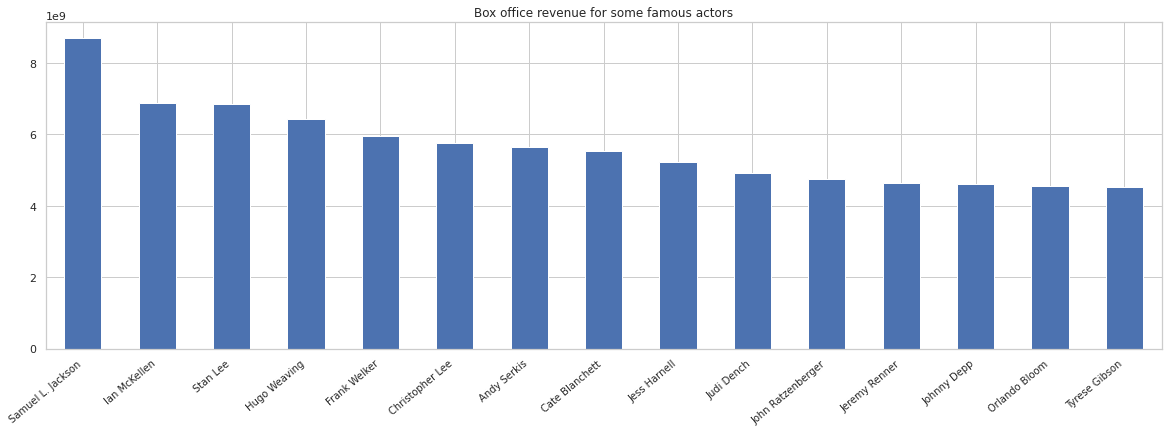

In [35]:
plt.figure(figsize=(20,6))
ax = pd.Series(revenue_by_cast).sort_values(ascending=False)[:15].plot.bar()
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=10)
plt.title("Box office revenue for some famous actors");

##Keywords

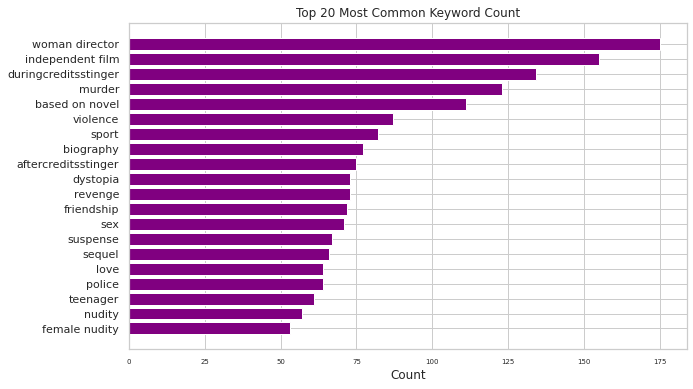

In [36]:
list_of_keywords = list(train['Keywords'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if (x != {} and not pd.isnull(x)) else []).values)
most_common_keywords=Counter([i for j in list_of_keywords for i in j]).most_common(20)

fig = plt.figure(figsize=(10, 6))
data=dict(most_common_keywords)
names = list(data.keys())
values = list(data.values())

plt.barh(sorted(range(len(data)),reverse=True),values,tick_label=names,color='purple')
plt.xlabel('Count')
plt.title('Top 20 Most Common Keyword Count')
plt.show()

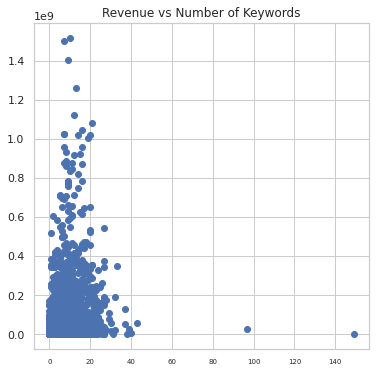

In [37]:
train['num_Keywords'] = train['Keywords'].apply(lambda x: len(ast.literal_eval(x)) if (x != {} and not pd.isnull(x)) else 0)

train['all_Keywords'] = train['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in ast.literal_eval(x)])) if (x != {} and not pd.isnull(x)) else '')
top_keywords = [m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(30)]
for g in top_keywords:
    train['keyword_' + g] = train['all_Keywords'].apply(lambda x: 1 if g in x else 0)
    
plt.figure(figsize=(6, 6))
plt.scatter(train['num_Keywords'], train['revenue'])
plt.title('Revenue vs Number of Keywords');

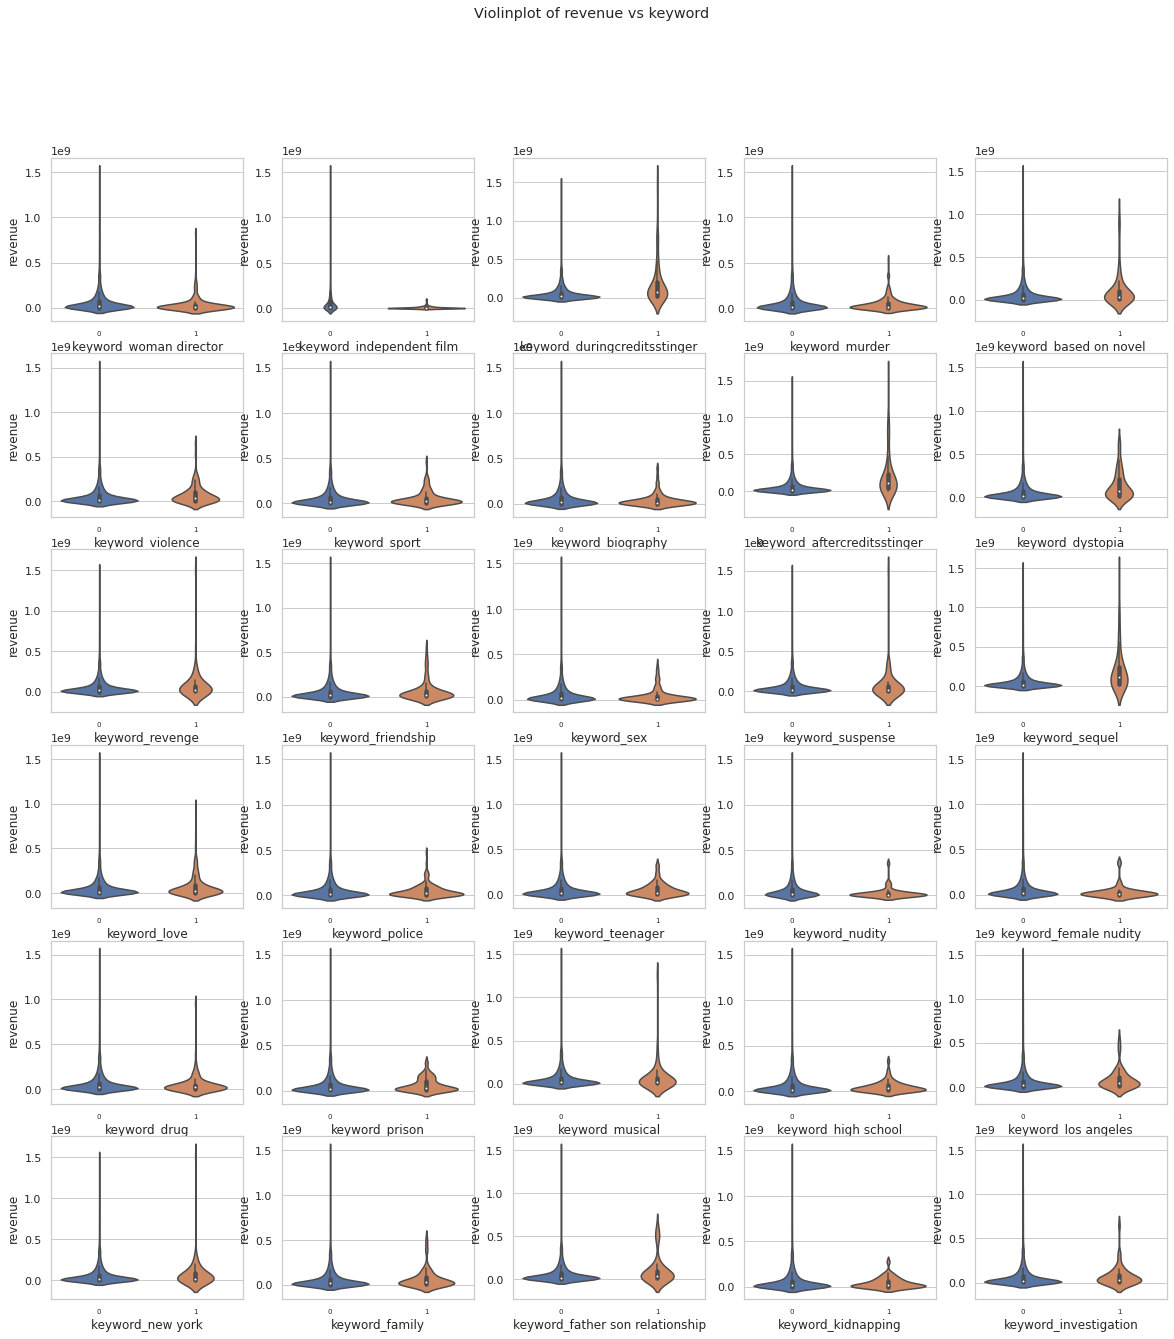

In [38]:
f, axes = plt.subplots(6, 5, figsize=(20, 21))
plt.suptitle('Violinplot of revenue vs keyword')
for i, e in enumerate([col for col in train.columns if 'keyword_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

## Crew

In [39]:
list_of_crew_names = list(train['crew'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if (x != {} and not pd.isnull(x)) else []).values)

train['num_crew'] = train['crew'].apply(lambda x: len(x) if (x != {} and not pd.isnull(x)) else 0)

top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(15)]
for g in top_crew_names:
    train['crew_name_' + g] = train['crew'].apply(lambda x: 1 if g in str(x) else 0)

train['genders_0_crew'] = train['crew'][(train['crew'].isnull()==False)].apply(lambda x: sum([1 for i in ast.literal_eval(x) if i['gender'] == 0]))
train['genders_1_crew'] = train['crew'][(train['crew'].isnull()==False)].apply(lambda x: sum([1 for i in ast.literal_eval(x) if i['gender'] == 1]))
train['genders_2_crew'] = train['crew'][(train['crew'].isnull()==False)].apply(lambda x: sum([1 for i in ast.literal_eval(x) if i['gender'] == 2])) 

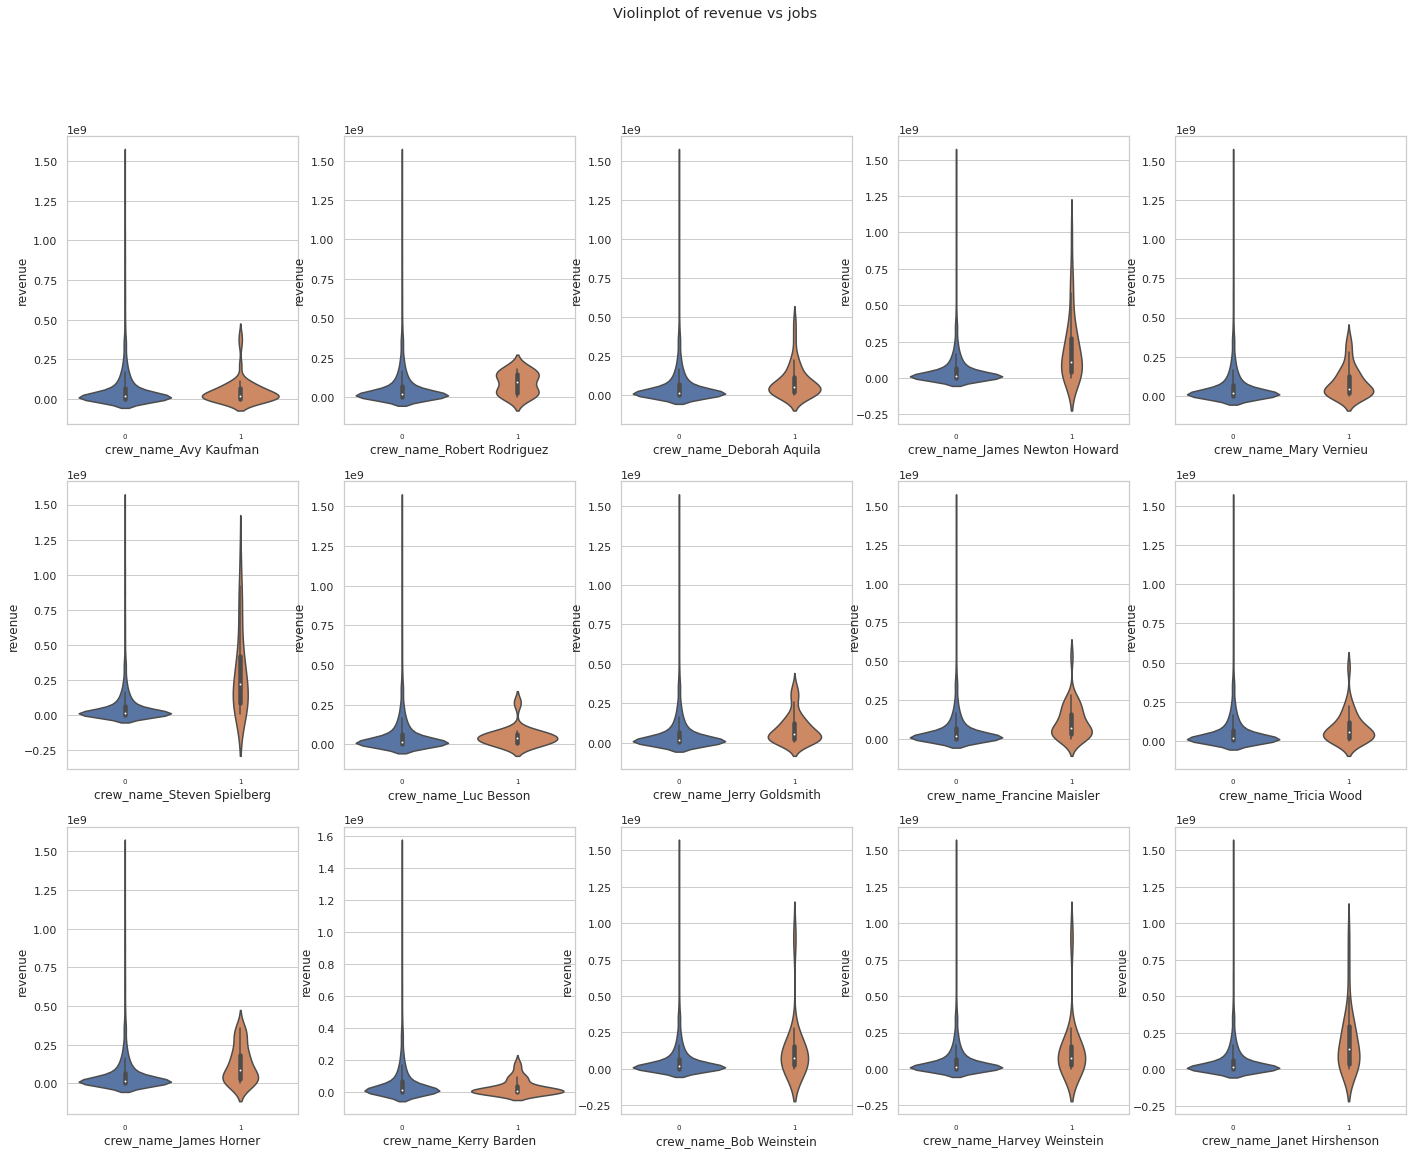

In [40]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs jobs')
for i, e in enumerate([col for col in train.columns if 'crew_name_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

In [41]:
non_na_collections_crew = train['crew'][(train['crew'].isnull()==False)]
crew_collections = {}
for df_entry in non_na_collections_crew:
  list_collections_crew = ast.literal_eval(df_entry)
  for entry in list_collections_crew:
    if (entry['name']) in crew_collections.keys():
      crew_collections[entry['name']]+=1
    else:
      crew_collections[entry['name']]=1
pd.Series(crew_collections).sort_values()      
revenue_by_crew = {}
for i, df_entry in enumerate(list_of_crew_names):
  for crew in df_entry:
    if crew in revenue_by_crew.keys():
      revenue_by_crew[crew] += train['revenue'].iloc[i]
    else:
      revenue_by_crew[crew] = train['revenue'].iloc[i]  

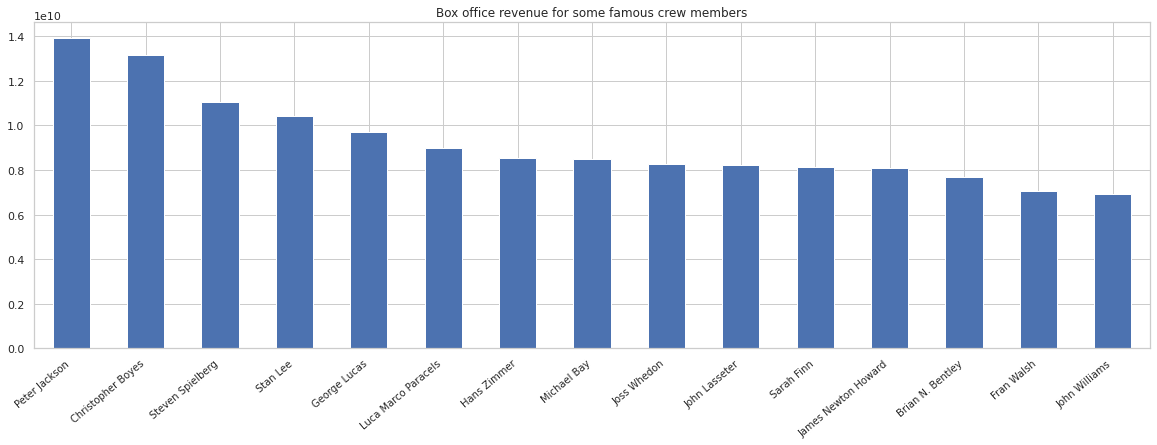

In [42]:
plt.figure(figsize=(20,6))
ax = pd.Series(revenue_by_crew).sort_values(ascending=False)[:15].plot.bar()
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=10)
plt.title("Box office revenue for some famous crew members");

## Languages

In [43]:
lim = 20
print('Number of different languages:', len(train['original_language'].unique()))
print('Numer of languages with atleast %i movies:'%lim, np.sum(train['original_language'].value_counts() > lim))

Number of different languages: 36
Numer of languages with atleast 20 movies: 7


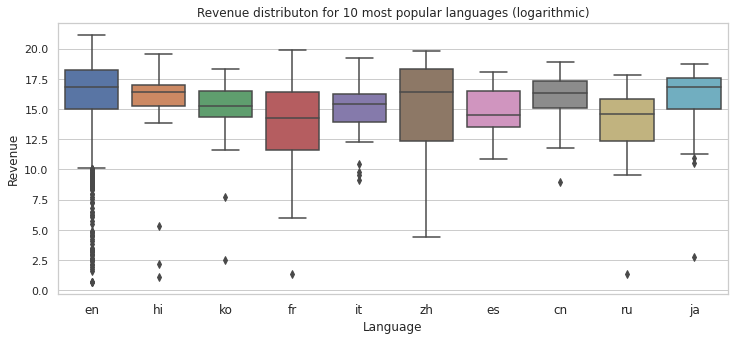

In [44]:
plt.figure(figsize = (12, 5))

plt.tick_params(axis = "x", labelsize = 12)
sns.boxplot(x = 'original_language', y = 'log_revenue', data = train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]);

plt.title('Revenue distributon for 10 most popular languages (logarithmic)');
plt.xlabel('Language');
plt.ylabel('Revenue');

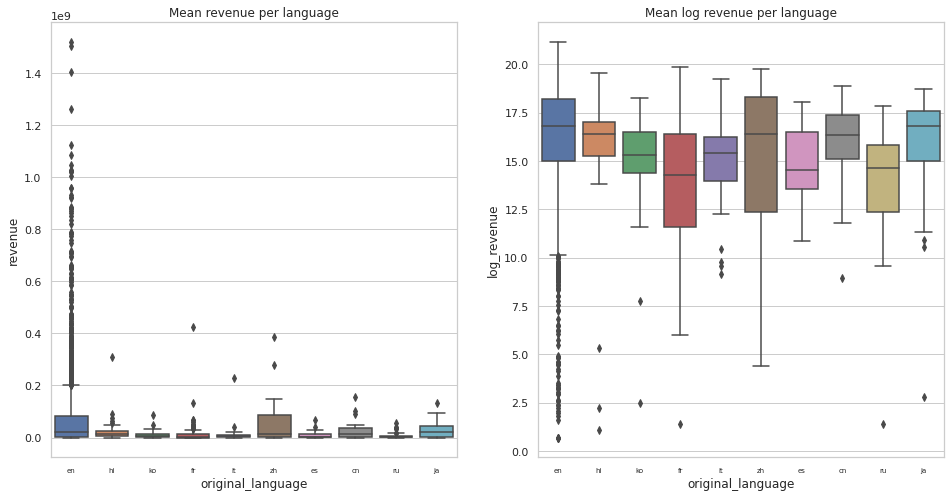

In [45]:
train['log_revenue'] = np.log1p(train['revenue'])
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(x='original_language', y='revenue', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]);
plt.title('Mean revenue per language');
plt.subplot(1, 2, 2)
sns.boxplot(x='original_language', y='log_revenue', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]);
plt.title('Mean log revenue per language');

## Popularity

In [46]:
print('Popularity feature description:\n\nMean: %.3f\nStandard Deviation: %.3f\nLimits: (minimum, maximum): (%.6f, %.3f)' %(train['popularity'].mean(), train['popularity'].std(), train['popularity'].min(), train['popularity'].max()))

Popularity feature description:

Mean: 8.463
Standard Deviation: 12.104
Limits: (minimum, maximum): (0.000001, 294.337)


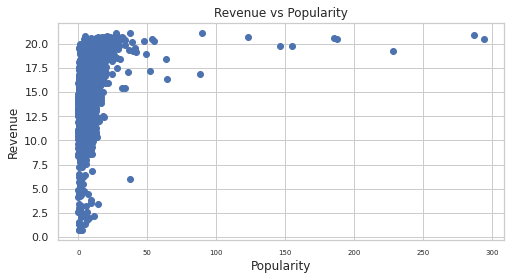

In [47]:
plt.scatter(train['popularity'], train['log_revenue'])
#plt.figsize((10, 10))

plt.title('Revenue vs Popularity');
plt.xlabel('Popularity');
plt.ylabel('Revenue');

## Original Title and Overview

In [48]:
trainTemp = train[['id','production_companies','production_countries','release_date', 'runtime', 'spoken_languages',  'revenue']]

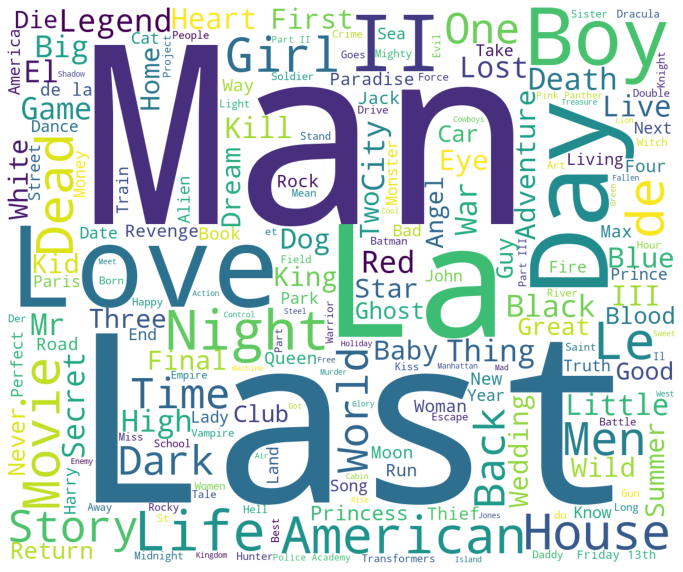

In [49]:
plt.figure(figsize = (12, 12))

text = ' '.join(train['original_title'].values)
wordcloud = WordCloud(max_font_size = None, background_color = 'white', width = 1200, height = 1000).generate(text)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

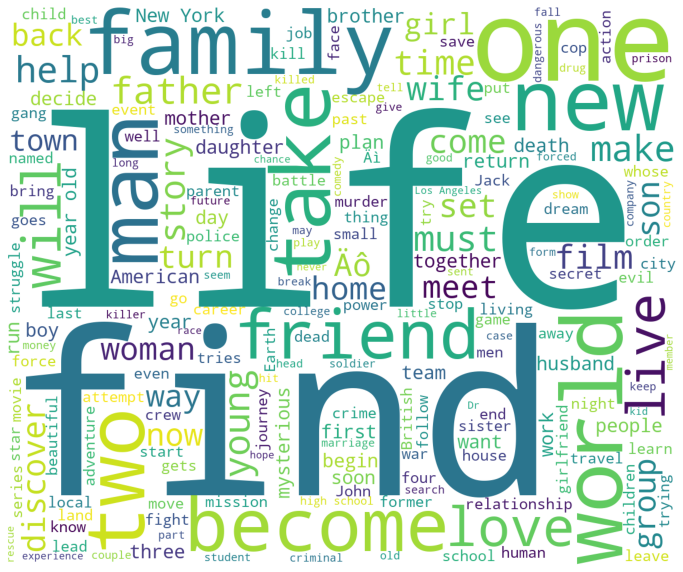

In [50]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['overview'].fillna('').values)
wordcloud = WordCloud(max_font_size = None, background_color = 'white', width = 1200, height = 1000).generate(text)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Production Country

In [51]:
non_na_collectionsPC = train['production_countries'][(train['production_countries'].isnull()==False)]
collections = {}
for df_entry in non_na_collectionsPC:
  list_collectionsPC = ast.literal_eval(df_entry)
  for entry in list_collectionsPC:
    if (entry['iso_3166_1']) in collections.keys():
      collections[entry['iso_3166_1']]+=1
    else:
      collections[entry['iso_3166_1']]=1
pd.Series(collections).sort_values()
list_of_collections = list(train['production_countries'].apply(lambda x: [i['iso_3166_1'] for i in ast.literal_eval(x)] if (x != {} and not pd.isnull(x)) else []).values)    

dfCountry = pd.DataFrame.from_dict(collections, orient='index',columns=['count'])

revenue_by_collection = {}
for i, df_entry in enumerate(list_of_collections):
  for collection in df_entry:
    if collection in revenue_by_collection.keys():
      revenue_by_collection[collection]+=train['revenue'].iloc[i]
    else:
      revenue_by_collection[collection]=train['revenue'].iloc[i]  

dfCountry["Revenue"] = pd.Series(revenue_by_collection)
dfCountry["Avg Revenue"] = dfCountry["Revenue"]/dfCountry["count"]

Text(0.5, 1.0, 'Number of movies vs Country')

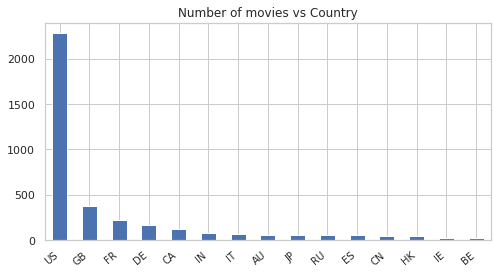

In [52]:
#plt.figure()
#axa = dfCountry['Revenue'].sort_values(ascending=False)[:15].plot(marker='o')
#axa.set_xticklabels(axa.get_xticklabels(), rotation=40, ha="right", fontsize=10)
#plt.title("Box office revenue vs Country")
plt.figure()
axa = dfCountry['count'].sort_values(ascending=False)[:15].plot.bar()
axa.set_xticklabels(axa.get_xticklabels(), rotation=40, ha="right", fontsize=10)
plt.title("Number of movies vs Country")

In [53]:
list_of_company_names = list(train['production_countries'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if (x != {} and not pd.isnull(x)) else []).values)
top_comp_names = [m[0] for m in Counter([i for j in list_of_company_names for i in j]).most_common(15)]
for g in top_comp_names:
    train['prod_country_' + g] = train['production_countries'].apply(lambda x: 1 if g in str(x) else 0)

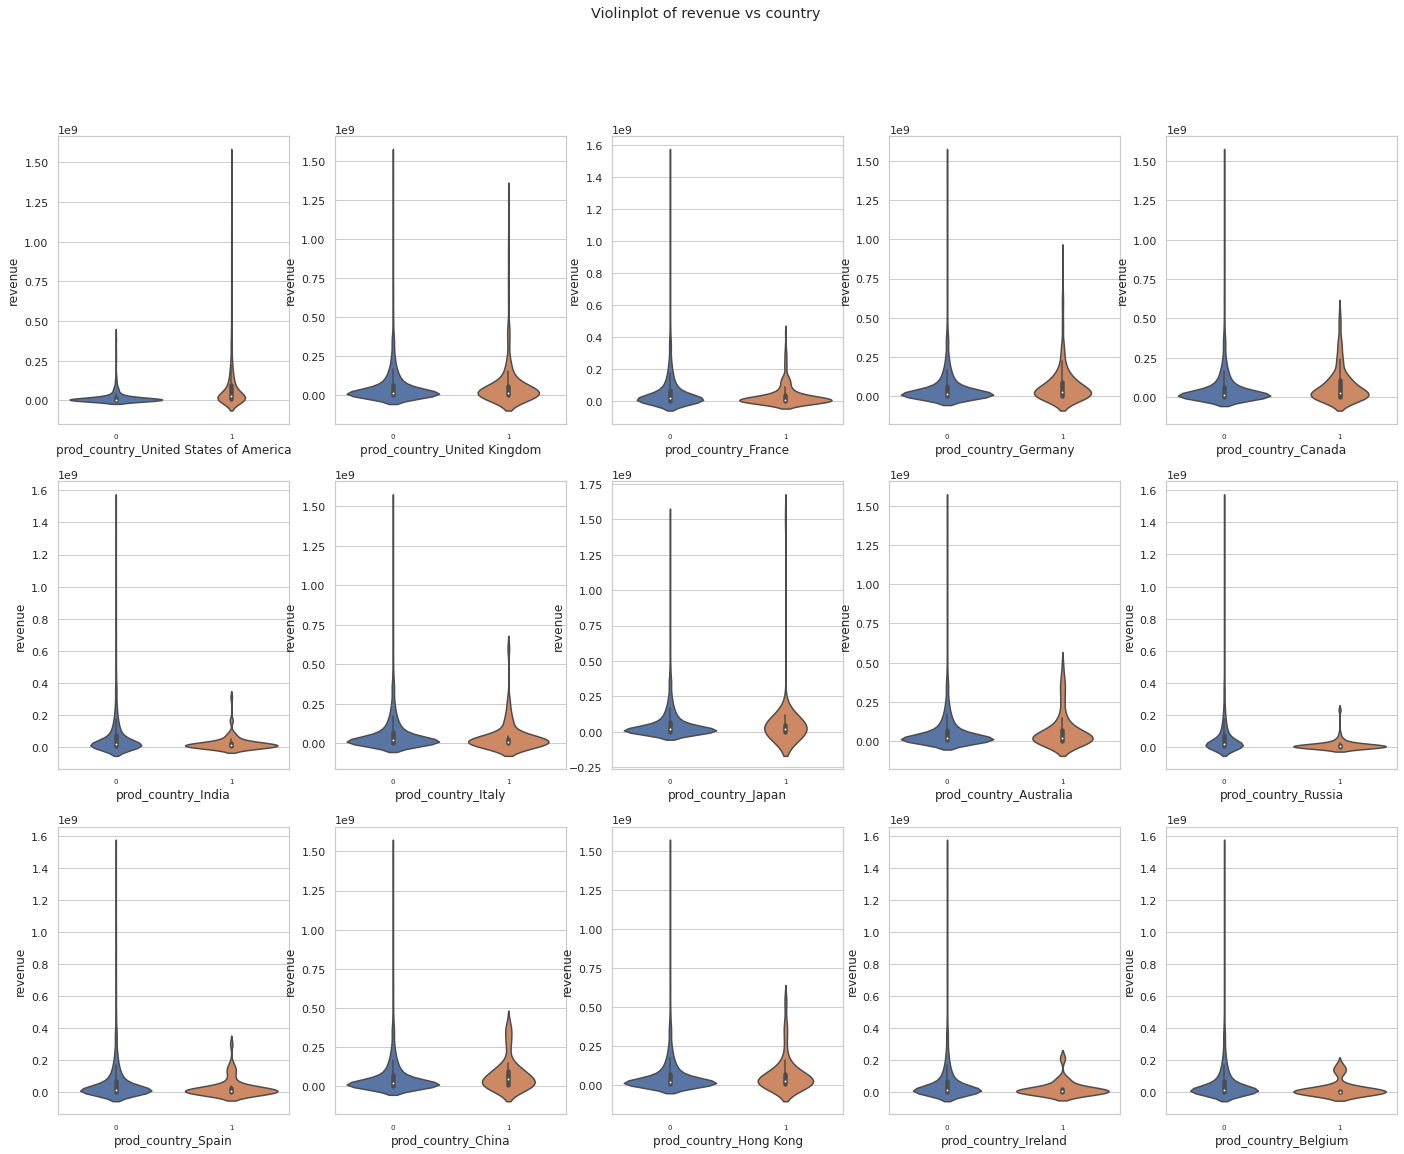

In [54]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs country')
for i, e in enumerate([col for col in train.columns if 'prod_country' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

## Release Date

In [55]:
d1 = train['release_date_year'].value_counts().sort_index()
d3 = train.groupby(['release_date_year'])['revenue'].mean()

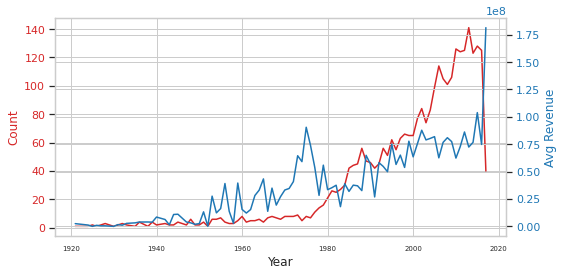

In [56]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Count', color=color)
ax1.plot(d1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Avg Revenue', color=color)  # we already handled the x-label with ax1
ax2.plot(d3, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

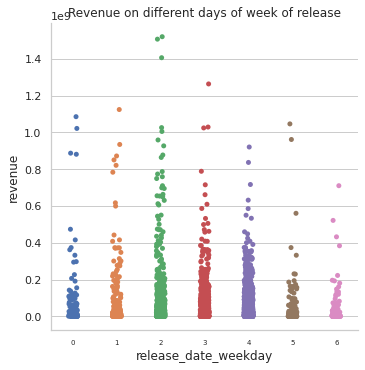

In [57]:
sns.catplot(x='release_date_weekday', y='revenue', data=train);
plt.title('Revenue on different days of week of release');

We can see that number of films and total revenue are growing, which is to be expected. But there were some years in the past with a high number of successful films, which brought high revenue. Surprisingly films releases on Wednesdays and on Thursdays tend to have a higher revenue.

Text(0, 0.5, 'Revenue (100 million dollars)')

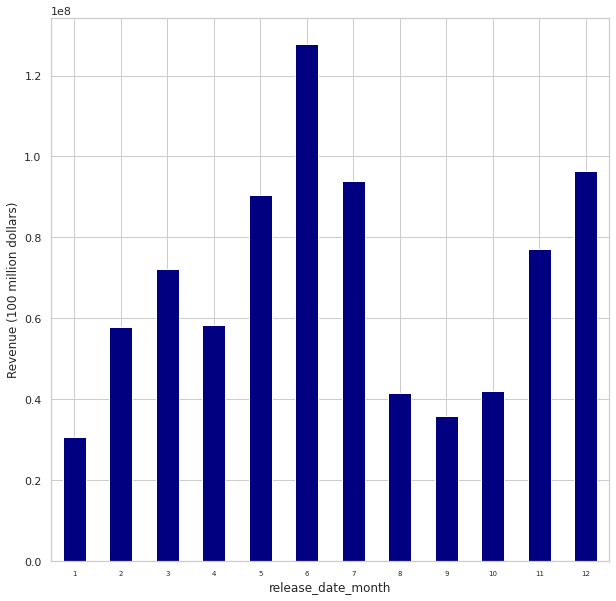

In [58]:
fig = plt.figure(figsize=(10,10))

train.groupby('release_date_month').agg('mean')['revenue'].plot(kind='bar',color='navy',rot=0)
plt.ylabel('Revenue (100 million dollars)')

## Runtime

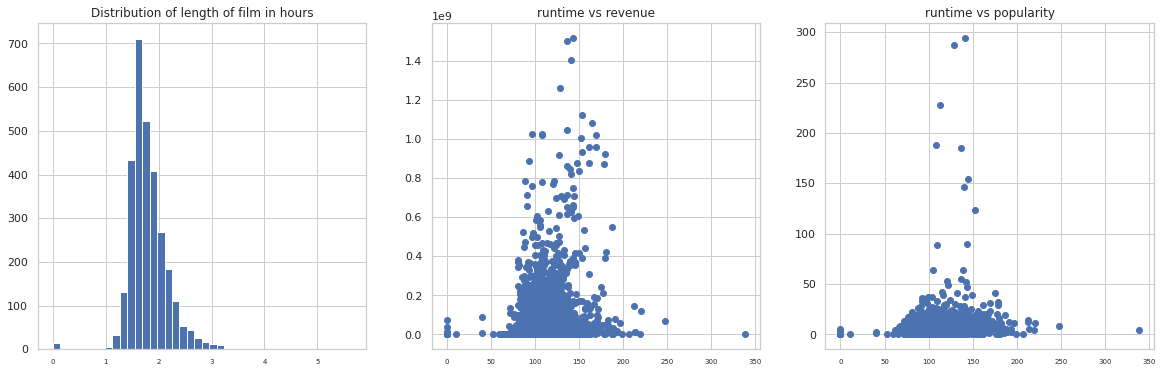

In [59]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.hist(train['runtime'].fillna(0) / 60, bins=40);
plt.title('Distribution of length of film in hours');
plt.subplot(1, 3, 2)
plt.scatter(train['runtime'].fillna(0), train['revenue'])
plt.title('runtime vs revenue');
plt.subplot(1, 3, 3)
plt.scatter(train['runtime'].fillna(0), train['popularity'])
plt.title('runtime vs popularity');

It seems that most of the films are 1.5-2 hour long and films with the highest revenue are also in this range

## Production Companies


In [60]:
non_na_collectionsComp = train['production_companies'][(train['production_companies'].isnull()==False)]
collections = {}
for df_entry in non_na_collectionsComp:
  list_collections = ast.literal_eval(df_entry)
  for entry in list_collections:
    if (entry['name']) in collections.keys():
      collections[entry['name']]+=1
    else:
      collections[entry['name']]=1
pd.Series(collections).sort_values()
list_of_collections = list(train['production_companies'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if (x != {} and not pd.isnull(x)) else []).values)    

revenue_by_collection = {}
for i, df_entry in enumerate(list_of_collections):
  for collection in df_entry:
    if collection in revenue_by_collection.keys():
      revenue_by_collection[collection]+=train['revenue'].iloc[i]
    else:
      revenue_by_collection[collection]=train['revenue'].iloc[i]

Text(0.5, 1.0, 'Box office revenue vs production Company')

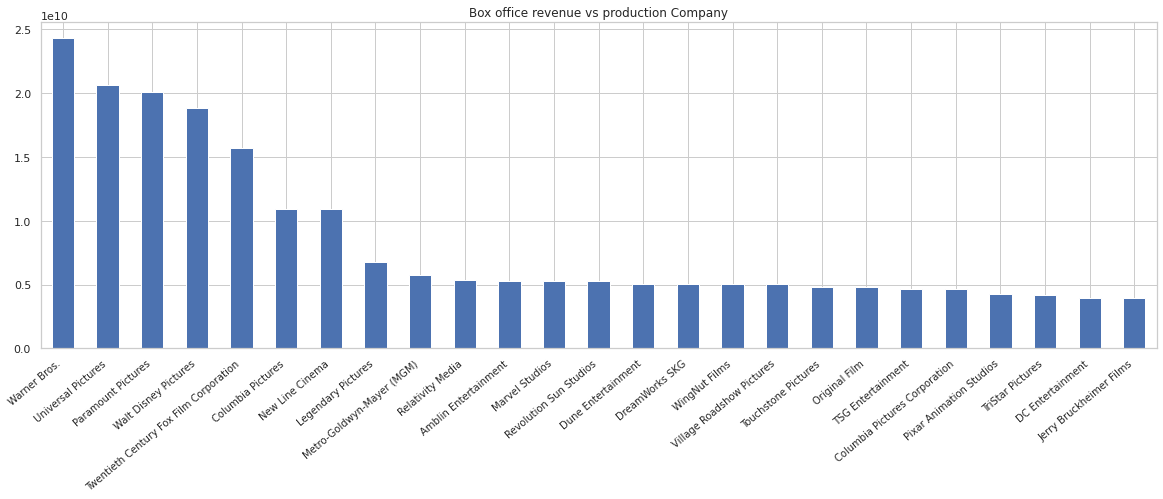

In [61]:
plt.figure(figsize=(20,6))
ax = pd.Series(revenue_by_collection).sort_values(ascending=False)[:25].plot.bar()
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=10)
plt.title("Box office revenue vs production Company")

## Spoken Languages

In [62]:
non_na_collectionsA = train['spoken_languages'][(train['spoken_languages'].isnull()==False)]
collections = {}
for df_entry in non_na_collectionsA:
  list_collectionsA = ast.literal_eval(df_entry)
  for entry in list_collectionsA:
    if (entry['iso_639_1']) in collections.keys():
      collections[entry['iso_639_1']]+=1
    else:
      collections[entry['iso_639_1']]=1
pd.Series(collections).sort_values()
list_of_collections = list(train['spoken_languages'].apply(lambda x: [i['iso_639_1'] for i in ast.literal_eval(x)] if (x != {} and not pd.isnull(x)) else []).values)    

dfSpoken = pd.DataFrame.from_dict(collections, orient='index',columns=['count'])
revenue_by_collection = {}
for i, df_entry in enumerate(list_of_collections):
  for collection in df_entry:
    if collection in revenue_by_collection.keys():
      revenue_by_collection[collection]+=train['revenue'].iloc[i]
    else:
      revenue_by_collection[collection]=train['revenue'].iloc[i]  
dfSpoken["Revenue"] = pd.Series(revenue_by_collection)
dfSpoken["Avg Revenue"] = dfSpoken["Revenue"]/dfSpoken["count"]

Text(0.5, 1.0, 'Number of movies vs lang')

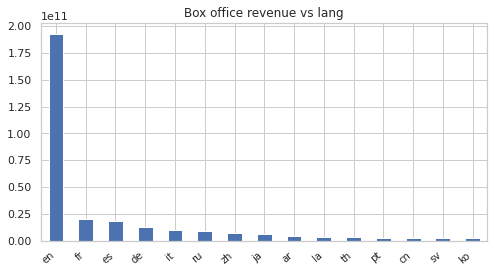

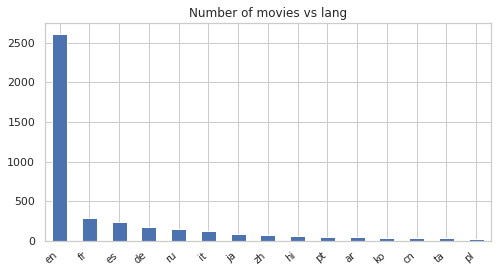

In [63]:
plt.figure()
axa = dfSpoken['Revenue'].sort_values(ascending=False)[:15].plot.bar()
axa.set_xticklabels(axa.get_xticklabels(), rotation=40, ha="right", fontsize=10)
plt.title("Box office revenue vs lang")
plt.figure()
axa = dfSpoken['count'].sort_values(ascending=False)[:15].plot.bar()
axa.set_xticklabels(axa.get_xticklabels(), rotation=40, ha="right", fontsize=10)
plt.title("Number of movies vs lang")

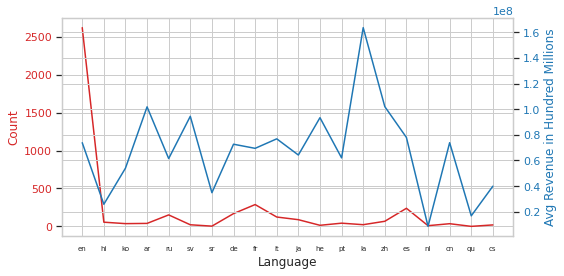

In [64]:
fig, ax1 = plt.subplots()
dfSpoken.sort_values(by=['count'])
d1 = dfSpoken['count'][:20]
d3 = dfSpoken['Avg Revenue'][:20]
color = 'tab:red'
ax1.set_xlabel('Language')
ax1.set_ylabel('Count', color=color)
ax1.plot(d1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Avg Revenue in Hundred Millions', color=color)  # we already handled the x-label with ax1
ax2.plot(d3, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Count of movies having english as a spoken language is very high while the average revenue is low for english due to high number of films. Similarly some of the films with less popular language have higher avg revenue due to less number of films

# Correlations and Null Values

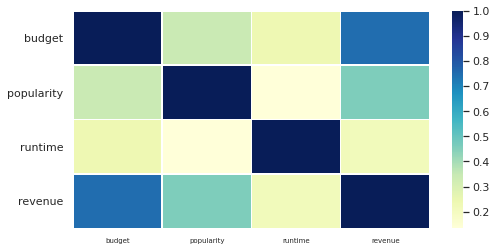

In [65]:
train = pd.read_csv('train.csv')
corr = train.drop('id', axis=1).corr()
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, cmap = "YlGnBu", linewidths = .5)
sns.set(font_scale = 1)

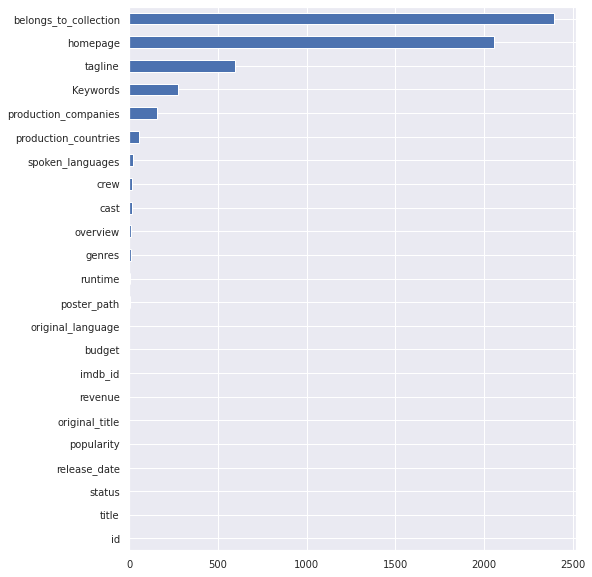

In [66]:
fig = plt.figure(figsize=(8, 10))
train.isna().sum().sort_values(ascending=True).plot(kind='barh', fontsize=10);